In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
pd.options.display.max_rows = 10
pd.options.display.max_columns = 500

In [2]:
###
## Load dataframe where each row is a single applicant
###

df = pd.read_csv('./df_test.csv')
df['ml_outcomes'] = df['ml_outcomes_div'].round(2)# + df['R']*0.13
#df['T'] = df['T'].round(2)#


In [3]:
df['ml_outcomes'].describe()

count    1000000.000000
mean           0.523725
std            0.198167
min            0.020000
25%            0.380000
50%            0.510000
75%            0.660000
max            1.230000
Name: ml_outcomes, dtype: float64

In [4]:
df['T']

0         62
1         53
2         60
3         42
4         40
          ..
999995    71
999996    48
999997    47
999998    50
999999    46
Name: T, Length: 1000000, dtype: int64

In [5]:
FRAC_ADMIT = df[['A']].sum()/len(df)


In [6]:
FRAC_ADMIT

A    0.485361
dtype: float64

In [7]:
len(df)

1000000

<AxesSubplot:>

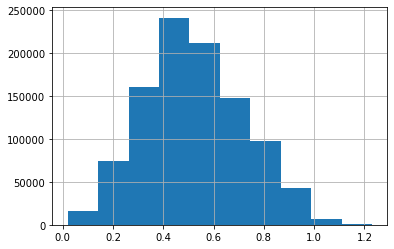

In [8]:
df['ml_outcomes'].hist()

In [9]:
##
# R = race, T = test score, ml_outcomes = expected utility from admitting, 
# ml_outcomes_{} counterfactual utility given race 
##

df[['R','T','ml_outcomes','T_black','T_white','ml_outcomes_black','ml_outcomes_white','ml_outcomes_decision','B_p']].sort_values(by='ml_outcomes')



,R,T,ml_outcomes,T_black,T_white,ml_outcomes_black,ml_outcomes_white,ml_outcomes_decision,B_p
799856,0,7,0.02,6,7,-4.079949,-3.784626,0,0
381520,0,8,0.02,6,8,-4.079949,-3.705448,0,0
802371,0,12,0.03,10,12,-3.763237,-3.388736,0,0
475990,0,10,0.03,7,10,-4.000771,-3.547092,0,0
195611,0,12,0.03,7,12,-4.000771,-3.388736,0,0
...,...,...,...,...,...,...,...,...,...
774157,1,106,1.23,106,124,3.837851,5.479200,1,1
733667,1,108,1.23,108,126,3.996207,5.637556,1,1
777126,1,104,1.23,104,121,3.679495,5.241666,1,1
961510,1,105,1.23,105,123,3.758673,5.400022,1,1


In [10]:
#df['ml_outcomes'] = df['ml_outcomes'] + 1*df['R']

In [11]:
###
## Get total utility from admitting people in a stratum 
###

df_ = df[['R','T','ml_outcomes']].groupby(['R','T']).sum().reset_index()

In [12]:
###
## Get number of people in each stratum
###

df_count = df[['R','T','ml_outcomes']].groupby(['R','T']).count().reset_index()
df_count.columns = ['R','T','Count']
df_count['N'] = df_count['Count']

In [13]:
###
## Merge summary tables to get one table with Race, Test Score, SUM(Utility), COUNT(applicants) per stratum
###

dff = df_.merge(df_count[['N']],left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False).reset_index().sort_values(by='index').reset_index()

In [14]:
# final info table
dff.sort_values(by='ml_outcomes')

,level_0,index,R,T,ml_outcomes,N
0,225,0,0,7,0.02,1
1,224,1,0,8,0.02,1
3,223,3,0,10,0.03,1
4,222,4,0,11,0.03,1
2,221,2,0,9,0.06,2
...,...,...,...,...,...,...
49,4,49,0,56,10957.96,21073
52,3,52,0,59,11026.38,19011
53,2,53,0,60,11038.80,18398
50,1,50,0,57,11087.82,20533


### Setup optimization problem 

In [15]:
from ortools.linear_solver import pywraplp


In [16]:
solver = pywraplp.Solver.CreateSolver('GLOP')


In [17]:
dff

,level_0,index,R,T,ml_outcomes,N
0,225,0,0,7,0.02,1
1,224,1,0,8,0.02,1
2,221,2,0,9,0.06,2
3,223,3,0,10,0.03,1
4,222,4,0,11,0.03,1
...,...,...,...,...,...,...
221,202,221,1,105,1.23,1
222,190,222,1,106,3.69,3
223,203,223,1,107,1.23,1
224,197,224,1,108,2.46,2


In [18]:
applicant_stratum = []
vars_cache = {}

# Objective: Maximize the expected utility of the admitted students
objective = solver.Objective()

# For each stratum
for ix, row in dff.iterrows():
    # probability of admission
    numvar = solver.NumVar(0.0, 1.0, str(ix))
    
    # store variable by index, and also by stratum R, T
    applicant_stratum.append(numvar)
    vars_cache[(row['R'],row['T'])] = numvar
    
    # Benefit of admitting people is total utility in that stratum
    objective.SetCoefficient(applicant_stratum[ix], float(row['ml_outcomes']))
objective.SetMaximization()


In [19]:
# Currently we have no constraints 
solver.NumConstraints()

0

In [20]:
# Constraint: At most K applicants
K = int(len(df)*FRAC_ADMIT)
print(K)
admit_quota = solver.Constraint(0, K)

# Total admits cannot exceed K 
for ix, row in dff.iterrows():
    admit_quota.SetCoefficient(applicant_stratum[ix], float(row['N']))

485361


In [21]:
# Now we have one constraint
solver.NumConstraints()

1

## Add Equalized Odds Constraints

In [22]:
from collections import Counter

def convertListToProb(raw_list):
    counts = dict(Counter(raw_list))
    probs = {}
    for test_score in counts:
        probs[test_score]  = counts[test_score]/float(len(raw_list))
    return [(probs[t], t) for t in probs]

In [23]:
T_blacks_list = df[df['R']==0][['T','T_black']].groupby('T')['T_black'].apply(list).reset_index(name='T_blacks')
T_blacks_list['probs'] = T_blacks_list['T_blacks'].apply(convertListToProb)
didntexist = 0
exists = 0
for ix, row in T_blacks_list.iterrows():
    cf_fair_stratum = solver.Constraint(0.0, 0.0)

    White_T = row['T']
    Blacks_Ts = row['probs']        
    cf_fair_stratum.SetCoefficient(vars_cache[(0.0, White_T)], -1.0)
    for prob in Blacks_Ts:
        if (1.0, prob[1]) not in vars_cache:
            vars_cache[(1.0, prob[1])] = solver.NumVar(0.0, 1.0, str((1.0, prob[1])))
            didntexist+=1
        else:
            exists+=1
        cf_fair_stratum.SetCoefficient(vars_cache[(1.0, prob[1])], prob[0])
didntexist,exists

(4, 963)

In [24]:
T_whites_list = df[df['R']==1][['T','T_white']].groupby('T')['T_white'].apply(list).reset_index(name='T_whites')
T_whites_list['probs'] = T_whites_list['T_whites'].apply(convertListToProb)
didntexist = 0
exists = 0

for ix, row in T_whites_list.iterrows():
    cf_fair_stratum = solver.Constraint(0.0, 0.0)

    Black_T = row['T']
    White_Ts = row['probs']
    
    cf_fair_stratum.SetCoefficient(vars_cache[(1.0, Black_T)], -1.0)
    for prob in White_Ts:
        if (0.0, prob[1]) not in vars_cache:
            vars_cache[(0.0, prob[1])] = solver.NumVar(0.0, 1.0, str((0.0, prob[1])))
            didntexist+=1
        else:
            exists+=1
            
        cf_fair_stratum.SetCoefficient(vars_cache[(0.0, prob[1])], prob[0])
didntexist,exists  

(2, 891)

In [25]:
solver.NumConstraints()

227

## Solve linear program

In [26]:
solver.ABNORMAL

4

In [27]:
status = solver.Solve()


In [28]:
status

0

In [29]:
solver.OPTIMAL

0

In [30]:
row = []
admit = []

for i in applicant_stratum:
    row.append(int(str(i)))
    admit.append(i.solution_value())

df_decisions = pd.DataFrame({'row_id':row,'decision':admit})

In [31]:
df_decisions

,row_id,decision
0,0,0.485351
1,1,0.485351
2,2,0.485351
3,3,0.485351
4,4,0.485351
...,...,...
221,221,1.000000
222,222,1.000000
223,223,1.000000
224,224,1.000000


In [32]:
dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)

,level_0,index,R,T,ml_outcomes,N,row_id,decision
51,0,51,0,58,11123.28,19863,51,0.485351
50,1,50,0,57,11087.82,20533,50,0.485351
53,2,53,0,60,11038.80,18398,53,0.485351
52,3,52,0,59,11026.38,19011,52,0.485351
49,4,49,0,56,10957.96,21073,49,0.485351
...,...,...,...,...,...,...,...,...
2,221,2,0,9,0.06,2,2,0.485351
4,222,4,0,11,0.03,1,4,0.485351
3,223,3,0,10,0.03,1,3,0.485351
1,224,1,0,8,0.02,1,1,0.485351


In [33]:
xxx_ = dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)
xxx_.sort_values(by='T')

,level_0,index,R,T,ml_outcomes,N,row_id,decision
122,219,122,1,4,0.26,1,122,0.485351
0,225,0,0,7,0.02,1,0,0.485351
123,215,123,1,7,0.54,2,123,0.485351
124,218,124,1,8,0.27,1,124,0.485351
1,224,1,0,8,0.02,1,1,0.485351
...,...,...,...,...,...,...,...,...
117,211,117,0,125,1.00,1,117,1.000000
118,210,118,0,127,1.00,1,118,1.000000
119,209,119,0,128,1.00,1,119,1.000000
120,208,120,0,130,1.00,1,120,1.000000


In [34]:
xxx = dff.merge(df_decisions,left_index=True,right_index=True).sort_values(by='ml_outcomes',ascending=False)
xxx

,level_0,index,R,T,ml_outcomes,N,row_id,decision
51,0,51,0,58,11123.28,19863,51,0.485351
50,1,50,0,57,11087.82,20533,50,0.485351
53,2,53,0,60,11038.80,18398,53,0.485351
52,3,52,0,59,11026.38,19011,52,0.485351
49,4,49,0,56,10957.96,21073,49,0.485351
...,...,...,...,...,...,...,...,...
2,221,2,0,9,0.06,2,2,0.485351
4,222,4,0,11,0.03,1,4,0.485351
3,223,3,0,10,0.03,1,3,0.485351
1,224,1,0,8,0.02,1,1,0.485351


In [35]:
len(xxx_)

226

In [36]:
xxx.to_csv('./decision.csv')

In [37]:
solution = pd.read_csv('./decision.csv')

In [38]:
xxx

,level_0,index,R,T,ml_outcomes,N,row_id,decision
51,0,51,0,58,11123.28,19863,51,0.485351
50,1,50,0,57,11087.82,20533,50,0.485351
53,2,53,0,60,11038.80,18398,53,0.485351
52,3,52,0,59,11026.38,19011,52,0.485351
49,4,49,0,56,10957.96,21073,49,0.485351
...,...,...,...,...,...,...,...,...
2,221,2,0,9,0.06,2,2,0.485351
4,222,4,0,11,0.03,1,4,0.485351
3,223,3,0,10,0.03,1,3,0.485351
1,224,1,0,8,0.02,1,1,0.485351


In [39]:
(xxx['ml_outcomes']*xxx['decision']).sum()

254201.4264320009

In [40]:
def maxMLOutcomes(frac_black=0.01):
    black_admits = int(K*frac_black)
    white_admits = int(K*(1-frac_black))
    
    b = df[df['R']==1].sort_values(by='ml_outcomes',ascending=False).head(n=black_admits)
    w = df[df['R']==0].sort_values(by='ml_outcomes',ascending=False).head(n=white_admits)
    
    return b['B_p'].sum() + w['B_p'].sum()    

In [41]:
def maxMLOutcomesBlack(frac_black=0.01):
    black_admits = int(K*frac_black)
    white_admits = int(K*(1-frac_black))
    
    b = df[df['R']==1].sort_values(by='ml_outcomes',ascending=False).head(n=black_admits)
    w = df[df['R']==0].sort_values(by='ml_outcomes',ascending=False).head(n=white_admits)
    
    return b['B_p'].sum()   

In [42]:
df['key'] = df['R'].astype(str)+'_'+df['T'].astype(str)
xxx['key'] = xxx['R'].astype(str)+'_'+xxx['T'].astype(str)

In [43]:
len(xxx)

226

In [44]:
admit_decisions = df.merge(xxx,how='left',on='key')
admit_decisions['decision_random'] = pd.Series([random.random() for x in range(0,len(admit_decisions))]) < FRAC_ADMIT['A']


FRAC_BLACK_POLICY = (admit_decisions['R_y'] * admit_decisions['decision']).sum()/admit_decisions['decision'].sum()
SUM_BP_POLICY = ( admit_decisions['B_p'] * admit_decisions['decision']).sum()

FRAC_RANDOM_POLICY = (admit_decisions['R_y'] * admit_decisions['decision_random']).sum()/admit_decisions['decision_random'].sum()
SUM_BP_RAND_POLICY = ( admit_decisions['B_p'] * admit_decisions['decision_random']).sum()


In [45]:
file = open('./lp_results.csv','w')
file.write('{}\t{}\t{}\n'.format('Policy Name','Frac Diverse Candidates','Total Graduated'))
file.write('{}\t{}\t{}\n'.format('Random',str(FRAC_RANDOM_POLICY),str(SUM_BP_RAND_POLICY)))
file.write('{}\t{}\t{}\n'.format('Counterfactual Fairness',str(FRAC_BLACK_POLICY),str(SUM_BP_POLICY)))
file.close()


In [46]:
(xxx['N']*xxx['decision']).sum()/len(df)

0.4853610000000002